# 1.Setup

In [5]:
import utils_image
import os
import PIL
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 2.数据

## 2.1 flowers

In [6]:
batch_size = 32
img_height = 180
img_width = 180
AUTOTUNE = tf.data.AUTOTUNE

data_root = utils_image.image_download(
    data_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    data_fname = "flower_photos",
    untar = True
)
data_root
# all_data_paths = utils_image.image_paths(data_root)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_root,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
)

train_class_names = train_ds.class_names
train_class_names
val_class_names = val_ds.class_names
val_class_names

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

num_classes = len(train_class_names)
num_classes

/Users/zfwang/.keras/datasets/flower_photos/roses
/Users/zfwang/.keras/datasets/flower_photos/sunflowers
/Users/zfwang/.keras/datasets/flower_photos/daisy
/Users/zfwang/.keras/datasets/flower_photos/dandelion
/Users/zfwang/.keras/datasets/flower_photos/tulips
/Users/zfwang/.keras/datasets/flower_photos/LICENSE.txt


PosixPath('/Users/zfwang/.keras/datasets/flower_photos')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

5

## 2.2 cifar10

In [7]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
print(train_images.shape)
print(test_images.shape)
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "trunk"]
num_classes = len(class_names)
num_classes

(50000, 32, 32, 3)
(10000, 32, 32, 3)


10

### 3.模型构建、编译、训练、验证、预测

## 3.1 

In [8]:
epochs = 10

model = models.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)))
model.add(layers.Conv2D(16, (3, 3), padding = "same", activation = "relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)
model.summary()
history = model.fit(
    # train_images, 
    # train_labels,
    # validation_data = (test_images, test_labels),
    train_ds,
    epochs = epochs,
    validation_data = val_ds,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

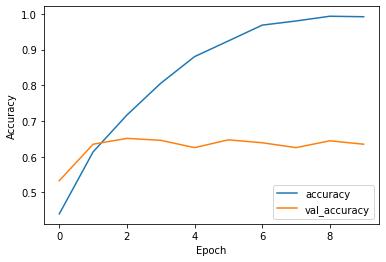

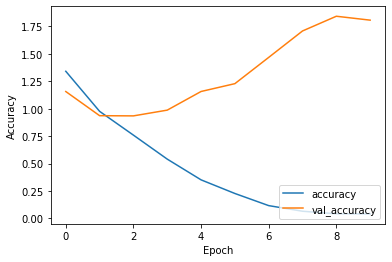

In [9]:
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.show();

plt.plot(history.history["loss"], label = "accuracy")
plt.plot(history.history["val_loss"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.show();

In [10]:
test_loss, test_accuracy = model.evaluate(
#     test_images, 
#     test_labels,
    val_ds,
    verbose = 2,
)

23/23 - 2s - loss: 1.8070 - accuracy: 0.6349


## 3.2

In [11]:
data_augmentation = tf.keras.models.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape = (img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

model = tf.keras.models.Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()
epochs = 15
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [12]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

OSError: image file is truncated (13 bytes not processed)